In [2]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [9]:
# download the estimates history and ratio analysis from Factset. You may want to use Python 3.9.6
# I rename the Excel of estimates history as "EPSestimates", and the file of ratio analysis as "Ratios"

import pandas as pd

# Load Excel file, skipping the first 7 rows and using row 8 as header
df = pd.read_excel("download1.xlsx", skiprows=7)

# Transpose the data
df_transposed = df.transpose()

# Set first row as new headers
df_transposed.columns = df_transposed.iloc[0]
df_transposed = df_transposed[1:]

# Reset index to make the transposed index (original column headers) into a column
df_transposed = df_transposed.reset_index()

# Rename the first column to 'Date' — this is the old index
df_transposed.rename(columns={df_transposed.columns[0]: 'Date'}, inplace=True)

print(df_transposed['Date'].unique())



["DEC '24" "SEP '24" "JUN '24" "MAR '24" "DEC '23" "SEP '23" "JUN '23"
 "MAR '23" "DEC '22" "SEP '22"]


In [10]:
# Clean and normalize the date strings
df_transposed['Date'] = (
    df_transposed['Date']
    .astype(str)
    .str.strip()
    .str.replace(r"[’‘`]", "'", regex=True)
    .str.upper()
)

# Convert from "DEC '24" to datetime
df_transposed['Date'] = pd.to_datetime(df_transposed['Date'], format="%b '%y", errors='coerce')

# Sort by date
df_transposed = df_transposed.sort_values(by='Date')
# Drop columns with missing values
df_transposed = df_transposed.dropna(axis=1, how='all')

# Preview the result
print(df_transposed.head())

Unnamed: 0       Date  NaN Gross Margin SG&A to Sales Operating Margin  \
9          2022-09-01  LTM    72.222911     50.635146        21.587765   
8          2022-12-01  LTM    72.854283     50.361333         22.49295   
7          2023-03-01  LTM    72.504423     50.674081        21.830341   
6          2023-06-01  LTM    72.546408     50.743551        21.802857   
5          2023-09-01  LTM    73.138215     49.421935         23.71628   

Unnamed: 0 Pretax Margin Net Margin Free Cash Flow Margin  \
9              21.385054  20.285293             41.435019   
8              23.679206  22.541191             40.538349   
7               24.42448  23.300511             43.520234   
6              26.626209  25.310126              42.85973   
5              29.465681  56.869076             44.217311   

Unnamed: 0 Free Cash Flow Conversion Ratio Capex To Sales  ... CFO/Total Debt  \
9                               204.261381       0.262328  ...       1.417997   
8                         

In [22]:
#import estimates
import pandas as pd

# Load the Excel file "EPSestimates", skipping the first 2 rows and using the third row as header
df_eps = pd.read_excel("downloadEH.xlsx", skiprows=2)

# Convert the "Date" column with the format "07 Apr '25" to datetime
df_eps['Date'] = pd.to_datetime(df_eps['Date'], format="%d %b '%y", errors='coerce')

# Sort by date
df_eps = df_eps.sort_values(by='Date')

# Rename the column 'Mean' to 'EPS estimate'
df_eps = df_eps.rename(columns={'Mean': 'EPS estimate'})

# View the first few rows after conversion
print(df_eps.head())


         Date  EPS estimate  Num of Est  Num Up  Num Down       Low      High  \
26 2023-02-28      0.348140           4       0         0  0.131962  0.554571   
25 2023-03-31      0.421069           4       1         0  0.131962  0.787745   
24 2023-04-28      0.468079           4       1         0  0.210000  0.787745   
23 2023-05-31      0.426368           4       2         2  0.140000  0.695920   
22 2023-06-30      0.385616           4       2         2  0.140000  0.695920   

     Std Dev  Chg (%)   Chg Amt  P/E (x)  PEG (x)  
26  0.208406        -         -  34.1473  1.57160  
25  0.305727  20.9483  0.072929  33.5528  1.54424  
24  0.257034  11.1643   0.04701  31.3481  1.44277  
23  0.228929 -8.91103 -0.041711  28.8737  1.26654  
22  0.233149 -9.55811 -0.040753  33.4101  1.74162  


In [23]:
# Extract year and month from the 'Date' column of both DataFrames
df_eps['Year'] = df_eps['Date'].dt.year
df_eps['Month'] = df_eps['Date'].dt.month

df_transposed['Year'] = df_transposed['Date'].dt.year
df_transposed['Month'] = df_transposed['Date'].dt.month

# Merge the two DataFrames on Year and Month
merged_df = pd.merge(df_eps, df_transposed, on=['Year', 'Month'], how='inner')


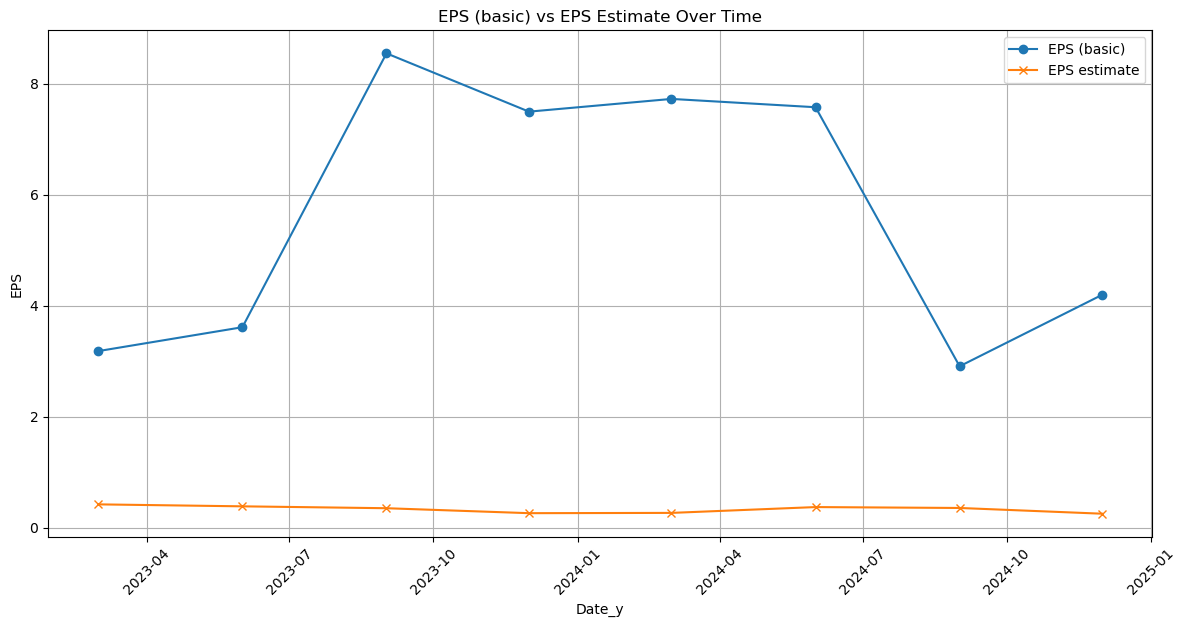

In [24]:
# Calculate the difference between actual EPS and estimated EPS
merged_df['EPS Difference'] = merged_df['EPS (basic)'] - merged_df['EPS estimate']

import matplotlib.pyplot as plt

# Sort by date for proper plotting
merged_df = merged_df.sort_values(by='Date_y')

# Plot
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Date_y'], merged_df['EPS (basic)'], label='EPS (basic)', marker='o')
plt.plot(merged_df['Date_y'], merged_df['EPS estimate'], label='EPS estimate', marker='x')
plt.xlabel('Date_y')
plt.ylabel('EPS')
plt.title('EPS (basic) vs EPS Estimate Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

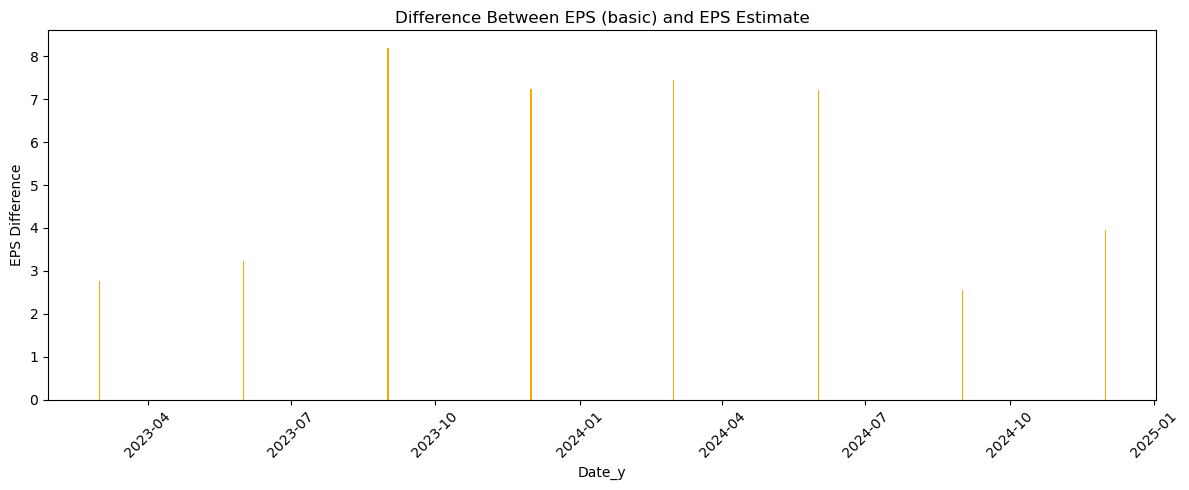

In [25]:
plt.figure(figsize=(12, 5))
plt.bar(merged_df['Date_y'], merged_df['EPS Difference'], color='orange')
plt.xlabel('Date_y')
plt.ylabel('EPS Difference')
plt.title('Difference Between EPS (basic) and EPS Estimate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

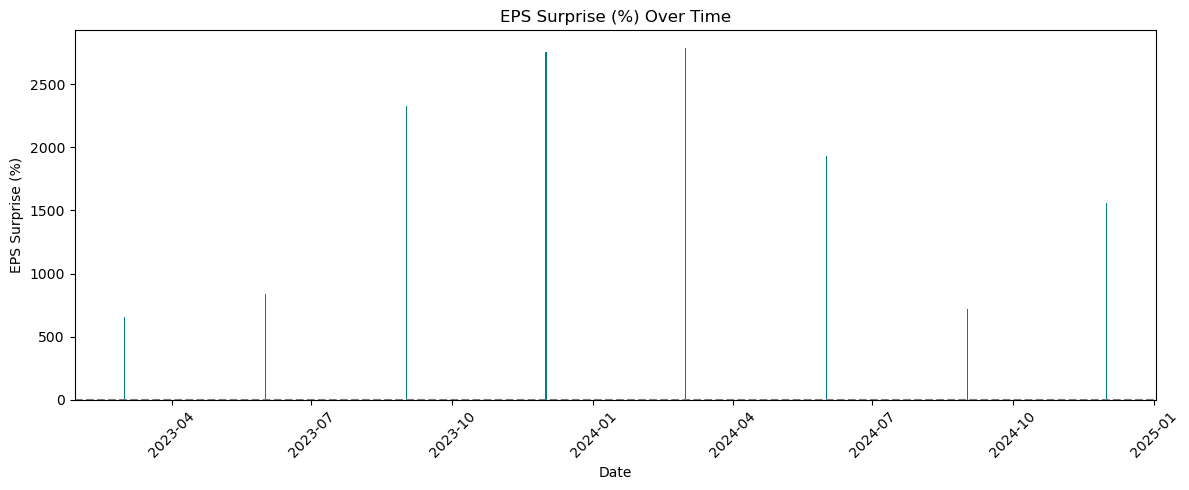

In [26]:
# Avoid division by zero by filtering out zero estimates
merged_df['EPS Surprise (%)'] = ((merged_df['EPS (basic)'] - merged_df['EPS estimate']) / merged_df['EPS estimate'].abs()) * 100
plt.figure(figsize=(12, 5))
plt.bar(merged_df['Date_y'], merged_df['EPS Surprise (%)'], color='teal')
plt.axhline(0, color='gray', linestyle='--')
plt.title('EPS Surprise (%) Over Time')
plt.xlabel('Date')
plt.ylabel('EPS Surprise (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()